# 溫度預測

每10分鐘紀錄14種天氣數值<br>
使用2009-2016年的資料去預測未來24小時的溫度

## https://www.kaggle.com/pankrzysiu/weather-archive-jena

In [1]:
import os

data_dir='D:\Final\code\LAB\keras\jena_climate_2009_2016'
fname=os.path.join(data_dir,'jena_climate_2009_2016.csv')

f=open(fname)
data=f.read()
f.close()

lines=data.split('\n')
header=lines[0].split(',')
lines=lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
print(lines[0])

01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30


In [3]:
import numpy as np

float_data=np.zeros((len(lines),len(header)-1))
for i,line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]#日期不紀錄
    float_data[i,:] = values
print(float_data.shape)

(420551, 14)


In [4]:
float_data[0]

array([ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
        9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
        1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
        1.75000e+00,  1.52300e+02])

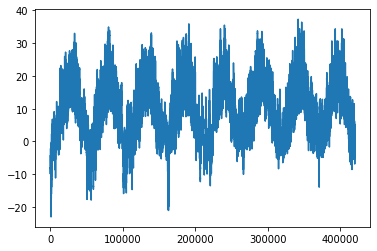

In [5]:
from matplotlib import pyplot as plt

temp = float_data[:,1]
plt.plot(range(len(temp)),temp)

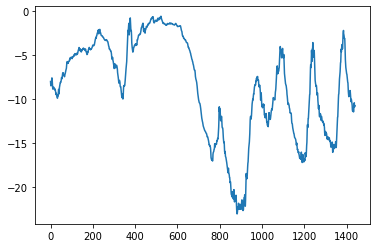

In [6]:
plt.plot(range(1440),temp[:1440]) #前10天記錄

## 標準化

In [7]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

# 定義資料產生器

產生器流程 :
Ａ點前１０天的資料作為訓練資料，Ａ點後２４小時為目標資料（標籤）

In [11]:
def generator(data,lookback,delay,min_index,max_index,shuffle=False,batch_size=128,step=6):
    
    if max_index is None:
        max_index = len(data) - delay -1
        
    i = min_index + lookback #i=A點
    while 1:
        if shuffle:
            rows = np.random.randint(min_index+lookback, max_index, size=batch_size) #從(min_index+lookback~max_index)隨機出現 128個數字
        else:
            if i+batch_size >=max_index:
                i=min_index+lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                        lookback // step,
                        data.shape[-1]))
        targets = np.zeros((len(rows), ))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [12]:
lookback = 1440   #過去10天的時間點
step = 6          #每1小時的區間
delay = 144       #未來的1天
batch_size = 128  #每批次樣本數量

# 訓練資料產生器
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,  
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)#從前200000筆資料產生訓練資料
# 驗證資料產生器
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
# 測試資料產生器
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size  #← 1...
test_steps = (len(float_data) - 300001 - lookback) // batch_size  #←2..

#1. val_gen 產生器需要運行多少次才可以產生完整的驗證集
#2. test_gen 產生器需要運行多少次才可以產生完整的測試集

# 用平均絕對誤差(MAE)評估

假設溫度時間序列資料是連續的，每天溫度變化有一定週期。<br>
yelid() next() : https://medium.com/@zhoumax/python-yield-a4caf2e6c0b8

In [28]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):   # 計算所有的驗證集資料
        samples, targets = next(val_gen) # 驅動產生器
        print(samples.shape) # shape=(128, 240, 14), 因為回朔為 1440 個時間點, 並以 6 個時間點為間隔進行取樣,所以共產生 1440/6=240 個時間點資料
        print(targets.shape)  # shape=(128,) 128 筆溫度答案 
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
        print(np.mean(batch_maes))  #　2.56488743498

evaluate_naive_method()

(128, 240, 14)
(128,)
0.3042308279267606
(128, 240, 14)
(128,)
0.28105146234936274
(128, 240, 14)
(128,)
0.3116057463229198
(128, 240, 14)
(128,)
0.2632069250573397
(128, 240, 14)
(128,)
0.2359644412953487
(128, 240, 14)
(128,)
0.2172188519471854
(128, 240, 14)
(128,)
0.22704444198430435
(128, 240, 14)
(128,)
0.24350689124422478
(128, 240, 14)
(128,)
0.26291226171761817
(128, 240, 14)
(128,)
0.24924811959997434
(128, 240, 14)
(128,)
0.23630172407016958
(128, 240, 14)
(128,)
0.23261513401974154
(128, 240, 14)
(128,)
0.23463197314512488
(128, 240, 14)
(128,)
0.23106557747200449
(128, 240, 14)
(128,)
0.24085712748461552
(128, 240, 14)
(128,)
0.25679432025525456
(128, 240, 14)
(128,)
0.25312570111068117
(128, 240, 14)
(128,)
0.2497303672887433
(128, 240, 14)
(128,)
0.24861772223382478
(128, 240, 14)
(128,)
0.24782858754091305
(128, 240, 14)
(128,)
0.25177851213783714
(128, 240, 14)
(128,)
0.2620777016854072
(128, 240, 14)
(128,)
0.26326121917050405
(128, 240, 14)
(128,)
0.26156911659421184

(128,)
0.26721576831396754
(128, 240, 14)
(128,)
0.2673200236576775
(128, 240, 14)
(128,)
0.267960569116732
(128, 240, 14)
(128,)
0.26782859577155177
(128, 240, 14)
(128,)
0.2673029987951524
(128, 240, 14)
(128,)
0.26723168009364345
(128, 240, 14)
(128,)
0.2676699215767253
(128, 240, 14)
(128,)
0.2678933636995008
(128, 240, 14)
(128,)
0.2685997188053235
(128, 240, 14)
(128,)
0.26882899136416527
(128, 240, 14)
(128,)
0.27013398485944806
(128, 240, 14)
(128,)
0.269815232439289
(128, 240, 14)
(128,)
0.2697857507661364
(128, 240, 14)
(128,)
0.27090149189104445
(128, 240, 14)
(128,)
0.2714405554166623
(128, 240, 14)
(128,)
0.2709574065421896
(128, 240, 14)
(128,)
0.27067528210426794
(128, 240, 14)
(128,)
0.2700920581690647
(128, 240, 14)
(128,)
0.2714719855264756
(128, 240, 14)
(128,)
0.27126178434707815
(128, 240, 14)
(128,)
0.2710860332396606
(128, 240, 14)
(128,)
0.27104060822082343
(128, 240, 14)
(128,)
0.2706682096442019
(128, 240, 14)
(128,)
0.2704528767360076
(128, 240, 14)
(128,)
0.

(128, 240, 14)
(128,)
0.2850495238861386
(128, 240, 14)
(128,)
0.2854439678299293
(128, 240, 14)
(128,)
0.28586106743968986
(128, 240, 14)
(128,)
0.28623165343779283
(128, 240, 14)
(128,)
0.2863025131739355
(128, 240, 14)
(128,)
0.28595836141703135
(128, 240, 14)
(128,)
0.285854213679736
(128, 240, 14)
(128,)
0.2859753151837378
(128, 240, 14)
(128,)
0.2864279038642864
(128, 240, 14)
(128,)
0.2861941949528534
(128, 240, 14)
(128,)
0.2861009156622503
(128, 240, 14)
(128,)
0.28603841578572464
(128, 240, 14)
(128,)
0.2855291742684018
(128, 240, 14)
(128,)
0.2851444831909626
(128, 240, 14)
(128,)
0.2848820186029459
(128, 240, 14)
(128,)
0.28486441751338304
(128, 240, 14)
(128,)
0.2849032171965949
(128, 240, 14)
(128,)
0.28443974555309026
(128, 240, 14)
(128,)
0.2845586773262799
(128, 240, 14)
(128,)
0.28533756702708096
(128, 240, 14)
(128,)
0.2854351178511538
(128, 240, 14)
(128,)
0.2850507515924536
(128, 240, 14)
(128,)
0.2845017164926441
(128, 240, 14)
(128,)
0.2842900213684175
(128, 240,

(128, 240, 14)
(128,)
0.2899179962985677
(128, 240, 14)
(128,)
0.29059109840092556
(128, 240, 14)
(128,)
0.2908406825114075
(128, 240, 14)
(128,)
0.29066484499668477
(128, 240, 14)
(128,)
0.29059480912816177
(128, 240, 14)
(128,)
0.2907537205354781
(128, 240, 14)
(128,)
0.2906145114567187
(128, 240, 14)
(128,)
0.290421462379457
(128, 240, 14)
(128,)
0.290079094831285
(128, 240, 14)
(128,)
0.2899186992234509
(128, 240, 14)
(128,)
0.2897378697349281
(128, 240, 14)
(128,)
0.28960055345598745
(128, 240, 14)
(128,)
0.28969112334600194
(128, 240, 14)
(128,)
0.28939373829733883
(128, 240, 14)
(128,)
0.2893619457197408
(128, 240, 14)
(128,)
0.2897070525193837
(128, 240, 14)
(128,)
0.29022067753264275
(128, 240, 14)
(128,)
0.29011631299617757
(128, 240, 14)
(128,)
0.29015928718721196
(128, 240, 14)
(128,)
0.28991954266975584
(128, 240, 14)
(128,)
0.29068699999459474
(128, 240, 14)
(128,)
0.2904805628417608
(128, 240, 14)
(128,)
0.2903549040162914
(128, 240, 14)
(128,)
0.2904241026508989
(128, 2

In [30]:
import tensorflow as tf
from tensorflow import keras

tf.__version__

'2.1.0'

# 密集連接層模型

In [31]:
model1=keras.Sequential([
    keras.layers.Flatten(input_shape=(lookback//step,float_data.shape[-1])),
    keras.layers.Dense(32,activation='relu'),
    keras.layers.Dense(1) #是迴歸問題所以沒有啟動函數
])
model1.summary()
model1.compile(optimizer=keras.optimizers.RMSprop(),
              loss='mae')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3360)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                107552    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = model1.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 769 steps
Epoch 1/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2750 - val_loss: 0.3456
Epoch 2/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2572 - val_loss: 0.3214
Epoch 3/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2471 - val_loss: 0.3189
Epoch 4/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2396 - val_loss: 0.3444
Epoch 5/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2338 - val_loss: 0.3226
Epoch 6/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2316 - val_loss: 0.3356
Epoch 7/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2246 - val_loss: 0.3366
Epoch 8/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2232 - val_loss: 0.3231
Epoch 9/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2189 - val_l

## val_loss =0.32 ，比 MAE還差

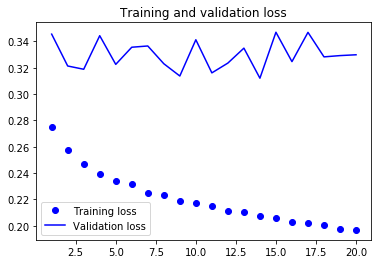

In [36]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# GRU (gate recurrent unit)

In [37]:
model2=keras.Sequential([
    keras.layers.GRU(32,input_shape=(None, float_data.shape[-1])),
    keras.layers.Dense(1)
])
model2.summary()
model2.compile(optimizer=keras.optimizers.RMSprop(),
              loss='mae')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                4608      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [38]:
history = model2.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 769 steps
Epoch 1/20
500/500 [==============================] - 21s 41ms/step - loss: 0.3126 - val_loss: 0.2715
Epoch 2/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2883 - val_loss: 0.2690
Epoch 3/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2793 - val_loss: 0.2624
Epoch 4/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2738 - val_loss: 0.2647
Epoch 5/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2681 - val_loss: 0.2646
Epoch 6/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2635 - val_loss: 0.2645
Epoch 7/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2583 - val_loss: 0.2636
Epoch 8/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2557 - val_loss: 0.2643
Epoch 9/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2514 - val_l

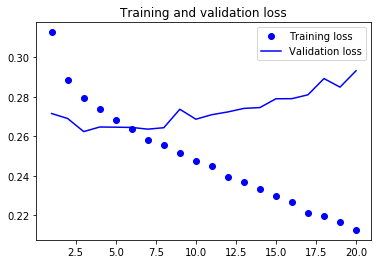

In [39]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 循環丟棄法

解決overfitting

In [41]:
model2=keras.Sequential([
    keras.layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])),
    keras.layers.Dense(1)
])
model2.summary()
model2.compile(optimizer=keras.optimizers.RMSprop(),
              loss='mae')
history = model2.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 32)                4608      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 769 steps
Epoch 1/40
500/500 [==============================] - 293s 586ms/step - loss: 0.3470 - val_loss: 0.2800
Epoch 2/40
500/500 [==============================] - 271s 541ms/step - loss: 0.3148 - val_loss: 0.2762
Epoch 3/40
500/500 [==============================] - 273s 545ms/step - loss: 0.3063 - val_loss: 0.2689
Epoch 4/40
500/500 [==============================] - 274s 547ms/step - loss: 0.3024 - val_loss: 0.2704
Epoc

KeyboardInterrupt: 

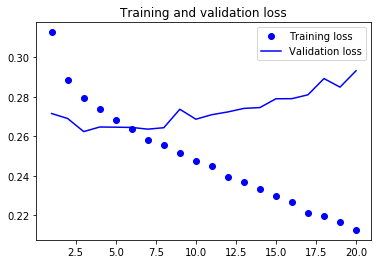

In [39]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 雙向RNN

In [ ]:
-
